## Is it a real chair?

****Using deep learning to categorise images.**** 

*This project is based off of 'Is it a bird?' by Jeremy Howard. Much of the code and structure is based off of his tutorial, however I have adapted and explained parts of it. 

Installing libraries. We will be using fastai as well as duckduckgo (for image search).

In [1]:
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# ignore any warnings or errors 
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have p

## Step 1: Download images of 3D chairs and real chairs

In [2]:
from duckduckgo_search import ddg_images # Import libraries
from fastcore.all import *

def search_images(term, max_images=100):
    """
    Returns fastai list of images based on search term and max number of images desired. 
    :param term: Search term, directly used to filter images, string.
    :param max_images: Integer representing the maximum number of images available to return.
    :return: L of images.
    """
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image') # L is an optimised list created by fastai. .itemgot creates a fastai list with all items with 'image'.

More on L: https://fastcore.fast.ai/foundation.html#l

Start with getting a test 3d chair photo. First get the url:

In [3]:
urls = search_images('3dchairblender photo', max_images=1) # Only want 1 image for now.
urls[0]

Searching for '3dchairblender photo'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://static.turbosquid.com/Preview/2019/02/20__15_54_11/1.pngF22BA4CE-A812-4B12-A68A-6755581FD0CCDefault.jpg'

Download and take a peek:

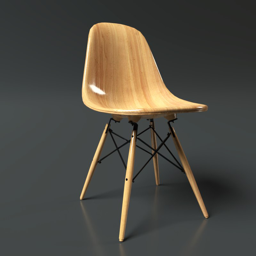

In [4]:
from fastdownload import download_url # fastai download library.
dest = '3dchair.jpg' # Name associated to image. No path, so will go in default output folder on Kaggle.
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import * # Required to view image.
im = Image.open(dest)
im.to_thumb(256,256) # Defining pixels

Now let's do the same with "chair photos":

Searching for 'chair photo'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


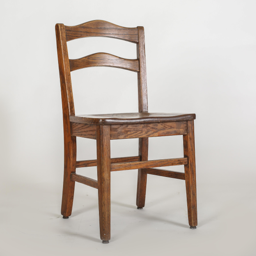

In [5]:
download_url(search_images('chair photo', max_images=1)[0], 'chair.jpg', show_progress=False)
Image.open('chair.jpg').to_thumb(256,256)

Seems good. Now we will get roughly 100 of each chair and 3dchairblender search results, and store them under their respective label.

In [6]:
searches = 'chair','3dchairblender'
path = Path('3dchair_or_not') # Overarching folder
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'chair photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for '3dchairblender photo'


## Step 2: Train our model

Remove failed images: 

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

dls stands for DataLoaders. It is an object from fastai created using DataBlock that does many useful things.
*     in blocks we need to specify our input (images) and our output (categories)
*     Next we get all our items with get_image_files, getting all the images inside of a path
*     splitter is what splits our data 80/20 into a training set and a validation set randomly.
*     In machine learning y is always the dependent variable/the target. In this case we want to predict the labels (chair, 3dchair), so y is the name of the file. 
*     The last line resizes the images by squishing it into 192x192.

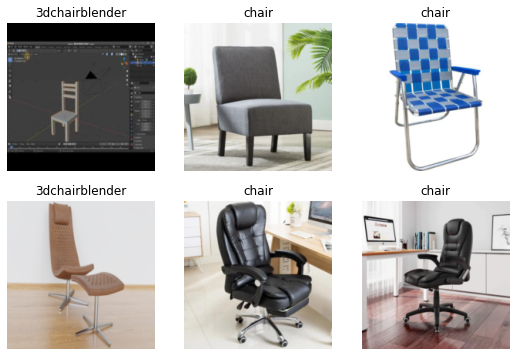

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6) # Shows 6 examples of what we are working with.

Now we're going to train the model. resnet18 is a CNN/ConvNet, meaning Convolutional Neural Network, used in Computer vision models. 
A website I used to understand this is: https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/

Essentially what CNN's do is break the image down into many different layers. It separates images into things such as RGB values, brightness and lines/patterns.  
It then uses a neural network like all deep learning machines to train itself to find patterns. Determining that if an image has this circle here, this brightness here, this rgb value here, then it has a high chance of being; for example a real chair. At least this is my understanding as of now.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # We are interested in the error rate so that we can determine how good the model is.
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.186112,1.045218,0.441176,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.406067,0.902339,0.411765,00:12
1,0.317409,0.735970,0.264706,00:11
2,0.244882,0.583418,0.235294,00:12
3,0.181240,0.419249,0.176471,00:11
4,0.142551,0.303202,0.147059,00:12


Fine-tuning is a process, where the more you do it the more accurate it becomes, however the longer it takes to complete. 
This model was done on resnet18, which was trained initially with ImageNet, a dataset with 14 million or so images. As such it has a solid foundation. 
In order to change this model to fit our needs we will have to slightly change the weights and biases to recognise the differences and patterns between a 3d software chair and real chair. Such is fine-tuning. 

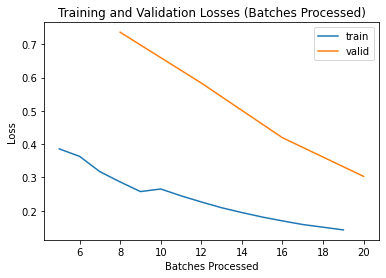

In [10]:
learn.recorder.plot_loss()
plt.xlabel('Batches Processed')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (Batches Processed)')
plt.show()


**Results can vary** 

Due to it only being run through 5 epochs the results are not reliable. We cannot ascertain whether it is overfitting or underfitting with the limited amount of data and resources. 

Sometimes the validation set experiences less loss, while at other times it experiences more loss than the training set. Typically they decrease at the same gradient, and we can say that the model is learning at a fixed rate. Perhaps given more data and time it will be able to confidently distinguish between 3D software and real life.

Another thing to note is that the error_rate usually always falls below 8%. 

## Step 3: Use our model

Time to test our model:

In [11]:
is_3dchair,_,probs = learn.predict(PILImage.create('3dchair.jpg'))
print(f"This is a: {is_3dchair}.")
print(f"Probability it's a 3d chair: {probs[0]:.4f}")

This is a: 3dchairblender.
Probability it's a 3d chair: 0.8980


Usually it is able to guess correctly with at least an 80% confidence. 

# In Conclusion:

CNN models are effective in quickly learning to categorise images based on their lighting and values. With a small dataset of 200 images, resnet18 was able to reach an average of 90% accuracy in their guesses. 

However the results are far less accurate when the search term is changed. The reason why the search term is currently '3dchairblender photos' is because simply searching for '3dchair photos' yielded results such as commercial marketing, or hyper-realism. Cases where 3d artists strive to achieve realism. The model took far longer to improve, and with 5 fine-tunes, only resulted in a 70% accuracy and a very minor improvement with each epoch. As such I conclude that resnet18 at least, is not yet able to discern the difference between a 3d artist's realism attempt and an actual photo of a chair. This is fair enough considering many CGI videos have been passed on as real in the past. 

The aim of this experiment was to see whether deep learning software could be used to discern 3d objects from real objects, as I thought it could possibly help in debunking fake videos or be used in 3d software for convenience. 